# Gillian Noonan HW13 - Jupyter Notebook - Code Grading No.2

## November 23, 2020

#####  **This code will obtain and use historical streamflow data from the Verde River to forecast a one-week and two-week flow value using the past two weeks of streamflow data from a USGS gauge.  A seasonal forecast for August-December 2020 is generated using historical minumum weekly flow from 1989 to present.


##  1: Import Modules

First we will import the modules that will be needed to run this code. For instructions on how to insall missing packages, please refer to: https://www.earthdatascience.org/courses/intro-to-earth-data-science/python-code-fundamentals/use-python-packages/use-conda-environments-and-install-packages/.  This code also imports an external function file named "Noonan_func.py" for the seasonal forecasting.

In [55]:
# %%
# Import the modules we will use

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import Noonan_func as nf
import urllib
import os
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import xarray as xr

print("....Import Successful")

....Import Successful


##  2: Acquire Streamflow Data
This section of code imports the latest streamflow data from USGS for station 095006000.   End date must be entered manually to most recent week end date.  The date column is split to year/month/day values for use in following code data manipulation.

In [56]:
# Replace parts of url with variables
site = '09506000'
start = '1989-01-01'
end = '2020-11-21'  # Update end date each week to Saturday

url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=" + \
       site + "&referred_module=sw&period=&begin_date=" + start + "&end_date=" + \
       end
data = pd.read_table(url, skiprows=30, names=['agency_cd', 'site_no',
                                              'datetime', 'flow', 'code'],
                     parse_dates=['datetime'])

# Expand the dates to year month day
data['year'] = pd.DatetimeIndex(data['datetime']).year
data['month'] = pd.DatetimeIndex(data['datetime']).month
data['day'] = pd.DatetimeIndex(data['datetime']).day

print("....Dataframe is Ready")


....Dataframe is Ready


##  3: Streamflow Gauge Location 
Next we will plot the location of the streamflow gauge used in forecasting (Stream gauge: 34.44833333, -111.7891667). **Figure 1** shows the location of the stream gauge with relation to all available streamflow gauges in Arizona, as well as other hydrological infomration such as watershed boundaries and location of rivers.  The Verde river is shown in bolded blue as this is our river of interest.

C:\Users\gilli\miniconda3\envs\hastools\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\gilli\miniconda3\envs\hastools\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\gilli\miniconda3\envs\hastools\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When maki

Figure 1. Location of stream gauge


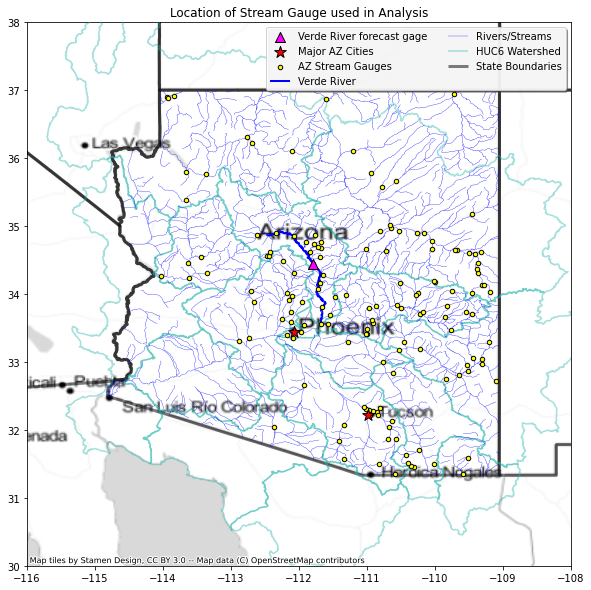

In [57]:
# %%
#  Gauges II USGS stream gauge dataset:
# Download here:
# https://water.usgs.gov/GIS/metadata/usgswrd/XML/gagesII_Sept2011.xml#stdorder

# Reading it using geopandas
file = os.path.join('data', 'gagesII_9322_point_shapefile',
                    'gagesII_9322_sept30_2011.shp')
gages = gpd.read_file(file)

# %%
# pull out AZ data
gages_AZ = gages[gages['STATE'] == 'AZ']

# %%
# //////////////
# USGS Watershed Boundary Dataset (WBD) for 2-digit Hydrologic Unit - 15
# (published 20201002)
# download: https://viewer.nationalmap.gov/basic/?basemap=b1&category=nhd&title=NHD%20View#productSearch
# Reading it using geopandas
file = os.path.join('data', 'WBD_15_HU2_Shape', 'Shape', 'WBDHU6.shp')
wshed = gpd.read_file(file)


# %%
# //////////////////////
# USGS National Boundary Dataset
# https://www.sciencebase.gov/catalog/item/59fa9f59e4b0531197affb13

# Reading it using geopandas
file = os.path.join('data', 'GOVTUNIT_Arizona_State_Shape',
                    'Shape', 'GU_StateOrTerritory.shp')
state = gpd.read_file(file)

# %%
# Dataset 3: Major rivers/streams
# Download USA Rivers and Streams from Esri here:
# https://hub.arcgis.com/datasets/esri::usa-rivers-and-streams?geometry=-115.952%2C31.858%2C-109.014%2C33.476

# Read in using geopandas
file = os.path.join('data', 'USA_Rivers_and_Streams-shp',
                    'USA_Rivers_and_Streams.shp')
rivers_USA = gpd.read_file(file)

# Filter to only AZ
rivers_AZ = rivers_USA[rivers_USA['State'] == 'AZ']

# Filter to only Verde
river_Verde = rivers_AZ[rivers_AZ['Name'] == 'Verde River']

# %%
# Dataset 4: Add point location of our stream gage
# https://waterdata.usgs.gov/nwis/inventory/?site_no=09506000&agency_cd=USGS
# Stream gauge:  34.44833333, -111.7891667
point_list = np.array([[-111.7891667, 34.44833333]])



# Make point into spatial feature
point_geom = [Point(xy) for xy in point_list]
point_geom

# Make a dataframe of the point
point_df = gpd.GeoDataFrame(point_geom, columns=['geometry'],
                            crs=state.crs)

# %%
# Add major cities
# Phoenix:  33.448, -112.074
# Tucson: 32.2226, -110.9747
cities_list = np.array([[-112.074, 33.448], [-110.9747, 32.2226]])

# %%
# make these into spatial features
cities_geom = [Point(xy) for xy in cities_list]

# %%
# map a dataframe of these points
cities_df = gpd.GeoDataFrame(cities_geom, columns=['geometry'],

                             crs=state.crs)

# reproject gages
gages_AZ_project = gages_AZ.to_crs(state.crs)
rivers_AZ_project = rivers_AZ.to_crs(state.crs)
river_Verde_project = river_Verde.to_crs(state.crs)


# %%
# Plot all layers 
fig, ax = plt.subplots(figsize=(10, 10))

point_df.plot(ax=ax, color='fuchsia', marker='^', edgecolor='black',
                    markersize=100, label='Verde River forecast gage', zorder=8)
cities_df.plot(ax=ax, color='red', marker='*', label="Major AZ Cities",
               markersize=150, edgecolor='black', zorder=7)
gages_AZ_project.plot(ax=ax, color='yellow', label="AZ Stream Gauges",
                      markersize=20, edgecolor='black', zorder=6)
river_Verde_project.plot(ax=ax, linewidth=2, label="Verde River", color='b', zorder=5)
rivers_AZ_project.plot(ax=ax, linewidth=0.3, color='b', zorder=4,
                       label='Rivers/Streams')
wshed.boundary.plot(ax=ax, color="lightseagreen", alpha=0.4, label="HUC6 Watershed", zorder=3)
state.boundary.plot(ax=ax, label="State Boundaries", alpha=0.5, linewidth=3, color="black", zorder=2)
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite, crs='epsg:4269', zorder=1)
ax.set_title("Location of Stream Gauge used in Analysis")
ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True,
          ncol=2, framealpha=0.9, facecolor='white', labelcolor='black')

xlim = ([-116, -108])
ylim = ([30, 38])
ax.set_xlim(xlim)
ax.set_ylim(ylim)



print("Figure 1. Location of stream gauge")
plt.show()

##  4: Visualize Recent Precipitation at Stream Gauge Location 
Here we take a look at precipitation at the direct location of the streamflow gage - This is accomplished using a pixel-based NetCDF file obtained for the direct latitude and longitude of our streamgauge. 
**Figure 2** shows the precipitation at the stream gauge for the full range of historical analysis (1989-present).  **Figure 3** shows precipitation along with weekly flow for the last 14 days at the stream gauge location.  

Figure 2. Historical precipitation at location of stream gauge - 1989 to present


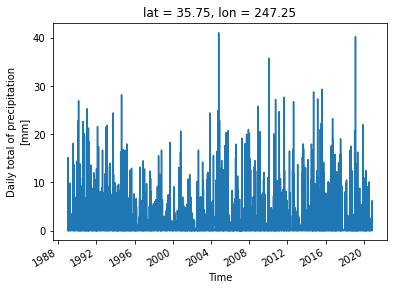

Figure 3. Last two weeks of precipitation at location of stream gauge


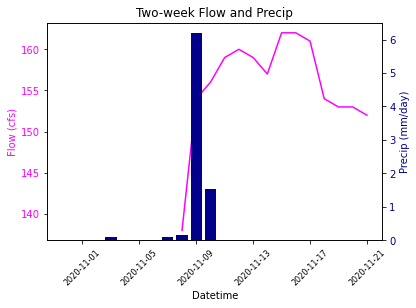

In [58]:
# STEP 3: Read in NetCDF - precip
# historical precip (1989-present) 'CPC Global Precipitation'
# pull out "precip" data
data_path = os.path.join('data',
                         'CPC Global Precipitation',
                         'X73.24.236.124.319.15.45.4.nc')
dataset2 = xr.open_dataset(data_path)
precip = dataset2['precip']

lat = dataset2["precip"]["lat"].values[0]
lon = dataset2["precip"]["lon"].values[0]

precip_pt = dataset2["precip"].sel(lat=lat, lon=lon)
print("Figure 2. Historical precipitation at location of stream gauge - 1989 to present")
precip_pt.plot.line()
plt.show()

# %%
# Convert to pandas dataframe
precip_df = precip_pt.to_dataframe()
precip_df

# Grab last two weeks - streamflow
two_wk_flow = data.tail(14)

# %%
# Grab last two weeks - precip
two_wk_precip = precip_df.tail(14)

# Time Series of Flow and Precip

fig, ax1 = plt.subplots()
color = 'fuchsia'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Flow (cfs)', color=color)
ax1.set(title="Two-week Flow and Precip")
ax1.plot(data["datetime"].tail(14), data["flow"].tail(14),
         color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=10)
ax1.tick_params(axis='x', labelcolor="black", labelsize=8, rotation=45)

ax2 = ax1.twinx()
color = 'darkblue'
ax2.set_ylabel('Precip (mm/day)', color=color)
ax2.bar(two_wk_precip.index, two_wk_precip["precip"],
        color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=10)
print("Figure 3. Last two weeks of precipitation at location of stream gauge")
plt.show()


##  5: Make Your Short-Term Streamflow Forecast 

The next section of code uses the most recent 14 days of streamflow data and predicts one- and two-week forecast values based on the trend upward or downward for flow and the overall 7-day or 14-day percent change in flow.  This code works well for continuing trends but not well when the trend shifts from positive to negative during the weekly period since there is a week lag before you notice the trend has shifted in direction.  
The mean flow for the last 7 and 14 days is provided, as well as the flow flucuation (% change) over the one-week and two-week periods.  **Figure 4** provides a visualization of the flow trend for the past 14 days at the selected stream gauge.

The mean flow for the last 7 days is: 156.71
The mean flow for the last 14 days is: 155.71


One-week Beginning and End Flow Values
162.0
152.0


Two-week Beginning and End Flow Values
138.0
152.0


Overall flow fluctuation in past 7 days was -6.17 percent.
Overall flow fluctuation in past 14 days was 10.14 percent.


Figure 4. Two-week flow trend


C:\Users\gilli\miniconda3\envs\hastools\lib\site-packages\numpy\core\fromnumeric.py:3370: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


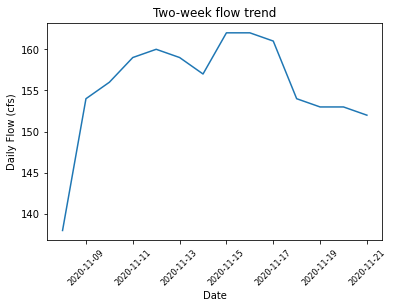

The one-week flow prediction is 147.0 cfs
The two-week flow prediction is 161.9 cfs


In [59]:
# # Look at tables of statistics for last 7 and 14 days
# Save tables of statistics as PNG files for markdown
data_weekly = data.tail(7)
data_two_wks = data.tail(14)

# Get one-week and two-week mean values
mean_1wk = round(np.mean(data_weekly)["flow"], 2)
print("The mean flow for the last 7 days is:", mean_1wk)

mean_2wk = round(np.mean(data_two_wks)["flow"], 2)
print("The mean flow for the last 14 days is:", mean_2wk)

# %%
# Get beginning and end flow values for one-week and two-week periods
print("\n")
print("One-week Beginning and End Flow Values")
first_val1 = data_weekly.flow.iloc[0]
last_val1 = data_weekly.flow.iloc[-1]
print(first_val1)
print(last_val1)

print("\n")
print("Two-week Beginning and End Flow Values")
first_val2 = data_two_wks.flow.iloc[0]
last_val2 = data_two_wks.flow.iloc[-1]
print(first_val2)
print(last_val2)

# %%
# Overall flow flucuation for last 7 and 14 days
# Calculate flucuation from start to end of last 7 days
perc_chng_total_1wk = ((last_val1 - first_val1)/first_val1)*100
print("\n")
print("Overall flow fluctuation in past 7 days was",
      round(perc_chng_total_1wk, 2), "percent.")

# Calculate flucuation from start to end of last 14 days
perc_chng_total_2wk = ((last_val2 - first_val2)/first_val2)*100
print("Overall flow fluctuation in past 14 days was",
      round(perc_chng_total_2wk, 2), "percent.")

# Look at visual trend over last two weeks
# Save plot for markdown
fig, ax = plt.subplots()
ax.plot(data_two_wks.datetime, data_two_wks.flow)
ax.set(title="Two-week flow trend")
ax.set(xlabel='Date', ylabel='Daily Flow (cfs)')
ax.tick_params(axis='x', labelcolor="black", labelsize=8, rotation=45)
print("\n")
print("Figure 4. Two-week flow trend")
plt.show()



# %%
# Trend-based prediction for one-week and two-week forecast values (Jill's Code)
# Based on percent change total from above code block.  If trend is upward,forecast a percentage higher, 
# if trend is downward, forecast a percentage lower

Jill_1wk = mean_1wk + (mean_1wk * (perc_chng_total_1wk/100))
print("The one-week flow prediction is", round(Jill_1wk, 1), "cfs")


Jill_2wk = mean_2wk + (mean_2wk * ((perc_chng_total_2wk+perc_chng_total_1wk)/100))
print("The two-week flow prediction is", round(Jill_2wk, 1), "cfs")

    


##  6: Make Long-Term Streamflow Forecast 

The next section of code uses historical minimum values recorded at the streamflow gauge to forecast the seasonal weekly values.  This method was chosen due to the "mega drought" being reported early in the semester.  It first takes the streamflow dataset and resamples it by weekly minimum.  It then makes an empty list, then populates this list with each week's forecast output.  It pulls the historical minimum values using two functions that are read in from the external 'Noonan_func.py' file.  For each seasonal time period, the historical minimum is listed and all historical values are plotted for visual comparison over the span of the dataset considered (1989-2019).


Plotted historical weekly minimum flows for  8 - 22 to 8 - 29


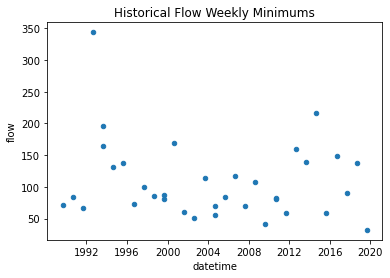

The overall historical weekly minimum flow for  8 - 22 to 8 - 29  is 32.0 cfs

Plotted historical weekly minimum flows for  8 - 30 to 9 - 5


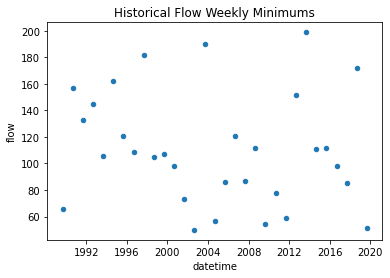

The overall historical weekly minimum flow for  8 - 30 to 9 - 5  is 49.9 cfs

Plotted historical weekly minimum flows for  9 - 6 to 9 - 12


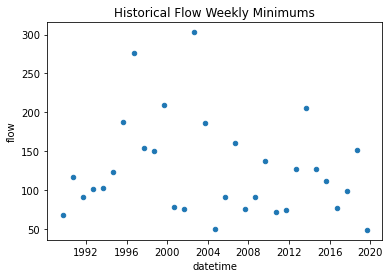

The overall historical weekly minimum flow for  9 - 6 to 9 - 12  is 48.6 cfs

Plotted historical weekly minimum flows for  9 - 13 to 9 - 19


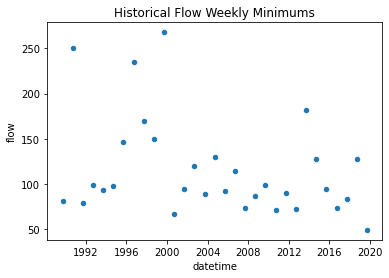

The overall historical weekly minimum flow for  9 - 13 to 9 - 19  is 48.9 cfs

Plotted historical weekly minimum flows for  9 - 20 to 9 - 26


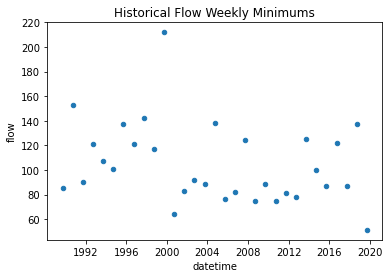

The overall historical weekly minimum flow for  9 - 20 to 9 - 26  is 51.2 cfs

Plotted historical weekly minimum flows for  9 - 27 to 10 - 3


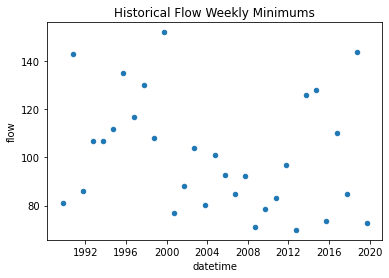

The overall historical weekly minimum flow for  9 - 27 to 10 - 3  is 69.9 cfs

Plotted historical weekly minimum flows for  10 - 4 to 10 - 10


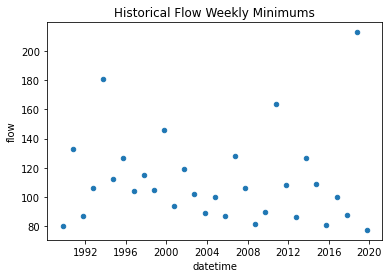

The overall historical weekly minimum flow for  10 - 4 to 10 - 10  is 77.3 cfs

Plotted historical weekly minimum flows for  10 - 11 to 10 - 17


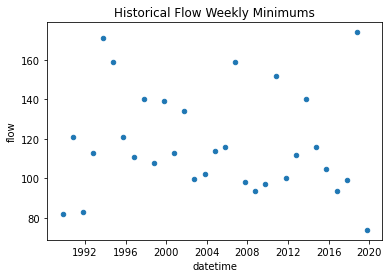

The overall historical weekly minimum flow for  10 - 11 to 10 - 17  is 73.9 cfs

Plotted historical weekly minimum flows for  10 - 18 to 10 - 24


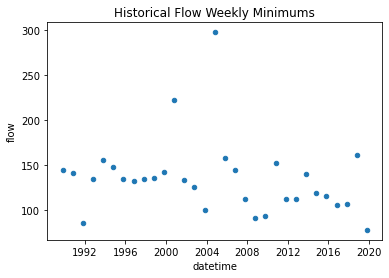

The overall historical weekly minimum flow for  10 - 18 to 10 - 24  is 77.8 cfs

Plotted historical weekly minimum flows for  10 - 25 to 10 - 31


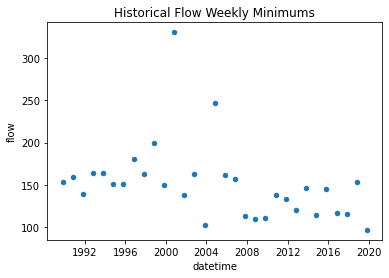

The overall historical weekly minimum flow for  10 - 25 to 10 - 31  is 97.1 cfs

Plotted historical weekly minimum flows for  11 - 1 to 11 - 7


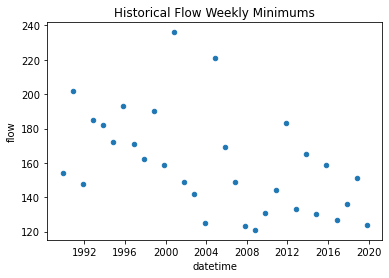

The overall historical weekly minimum flow for  11 - 1 to 11 - 7  is 121.0 cfs

Plotted historical weekly minimum flows for  11 - 8 to 11 - 14


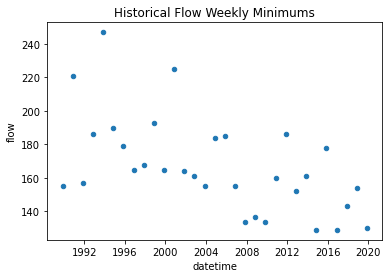

The overall historical weekly minimum flow for  11 - 8 to 11 - 14  is 129.0 cfs

Plotted historical weekly minimum flows for  11 - 15 to 11 - 21


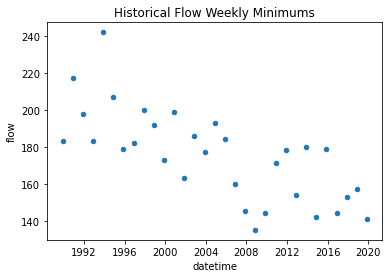

The overall historical weekly minimum flow for  11 - 15 to 11 - 21  is 135.0 cfs

Plotted historical weekly minimum flows for  11 - 22 to 11 - 28


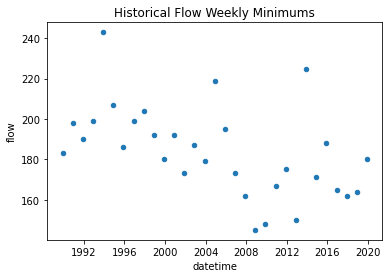

The overall historical weekly minimum flow for  11 - 22 to 11 - 28  is 145.0 cfs

Plotted historical weekly minimum flows for  11 - 29 to 12 - 5


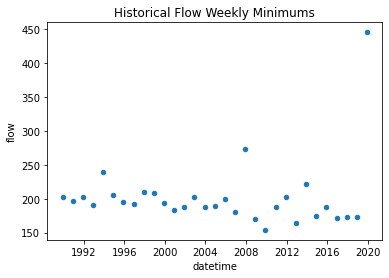

The overall historical weekly minimum flow for  11 - 29 to 12 - 5  is 154.0 cfs

Plotted historical weekly minimum flows for  12 - 6 to 12 - 12


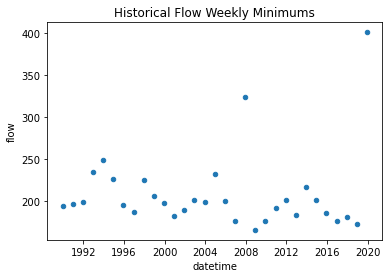

The overall historical weekly minimum flow for  12 - 6 to 12 - 12  is 166.0 cfs


Seasonal forecast list = [32.0, 49.9, 48.6, 48.9, 51.2, 69.9, 77.3, 73.9, 77.8, 97.1, 121.0, 129.0, 135.0, 145.0, 154.0, 166.0]


In [60]:
# Create dataset to generate long term forecast based on historical minimums

# First aggregate flow values to weekly MINIMUM
data_week_min = data.resample("W-SAT", on='datetime').min()

# Reset index to be first day of week instead of last day
data_week_min = data_week_min.set_index("datetime")

# Plot historical weekly flows for each forecast week
# Use functions 'weekly_min1' or 'weekly_min2' to grab historical minimum flow

# Set empty list
seasonal_list = list()

# Wk1 historical min (8/22 - 8/29)
month1 = 8
day_more = 22
day_less = 29
nf.weekly_min1(data_week_min, month1, day_more, day_less, seasonal_list)

# Wk2 historical min (8/30 - 9/5)
month1 = 8
day1 = 30
month2 = 9
day2 = 5
nf.weekly_min2(data_week_min, month1, day1, month2, day2, seasonal_list)

# Wk3 historical min (9/6 - 9/12)
month1 = 9
day_more = 6
day_less = 12
nf.weekly_min1(data_week_min, month1, day_more, day_less, seasonal_list)

# Wk4 historical min (9/13 - 9/19)
month1 = 9
day_more = 13
day_less = 19
nf.weekly_min1(data_week_min, month1, day_more, day_less, seasonal_list)

# Wk5 historical min (9/20 - 9/26)
month1 = 9
day_more = 20
day_less = 26
nf.weekly_min1(data_week_min, month1, day_more, day_less, seasonal_list)

# Wk6 historical min (9/27 - 10/3)
month1 = 9
day1 = 27
month2 = 10
day2 = 3
nf.weekly_min2(data_week_min, month1, day1, month2, day2, seasonal_list)

# Wk7 historical min (10/4 - 10/10)
month1 = 10
day_more = 4
day_less = 10
nf.weekly_min1(data_week_min, month1, day_more, day_less, seasonal_list)

# Wk8 historical min (10/11 - 10/17)
month1 = 10
day_more = 11
day_less = 17
nf.weekly_min1(data_week_min, month1, day_more, day_less, seasonal_list)

# Wk9 historical min (10/18 - 10/24)
month1 = 10
day_more = 18
day_less = 24
nf.weekly_min1(data_week_min, month1, day_more, day_less, seasonal_list)

# Wk10 historical min (10/25 - 10/31)
month1 = 10
day_more = 25
day_less = 31
nf.weekly_min1(data_week_min, month1, day_more, day_less, seasonal_list)

# Wk11 historical min (11/1 - 11/7)
month1 = 11
day_more = 1
day_less = 7
nf.weekly_min1(data_week_min, month1, day_more, day_less, seasonal_list)

# Wk12 historical min (11/8 - 11/14)
month1 = 11
day_more = 8
day_less = 14
nf.weekly_min1(data_week_min, month1, day_more, day_less, seasonal_list)

# Wk13 historical min (11/15 - 11/21)
month1 = 11
day_more = 15
day_less = 21
nf.weekly_min1(data_week_min, month1, day_more, day_less, seasonal_list)

# Wk14 historical min (11/22 - 11/28)
month1 = 11
day_more = 22
day_less = 28
nf.weekly_min1(data_week_min, month1, day_more, day_less, seasonal_list)

# Wk15 historical min (11/29 - 12/5)
month1 = 11
day1 = 29
month2 = 12
day2 = 5
nf.weekly_min2(data_week_min, month1, day1, month2, day2, seasonal_list)

# Wk16 historical min (12/6 - 12/12)
month1 = 12
day_more = 6
day_less = 12
nf.weekly_min1(data_week_min, month1, day_more, day_less, seasonal_list)

# Print 16 week forecast values
print("\n")
print("Seasonal forecast list =", seasonal_list)

# %%

##  7: Final Summary Forecast Results

The final one- and two-week forecast and seasonal forecast values, using the above code blocks, are summarized below.

In [61]:
print("The one- and two-week forecast streamflow values are:")
print("\n")
print("One-week flow forecast (cfs) =", Jill_1wk)
print("Two-week flow forecast (cfs) =",Jill_2wk)

print("\n")
print("The Seasonal Forecast List (in cfs) for weekly intervals starting on 8/22/20 and ending on 12/12/20 are:")
print("\n")
print(seasonal_list)



The one- and two-week forecast streamflow values are:


One-week flow forecast (cfs) = 147.03654320987656
Two-week flow forecast (cfs) = 161.89493827160496


The Seasonal Forecast List (in cfs) for weekly intervals starting on 8/22/20 and ending on 12/12/20 are:


[32.0, 49.9, 48.6, 48.9, 51.2, 69.9, 77.3, 73.9, 77.8, 97.1, 121.0, 129.0, 135.0, 145.0, 154.0, 166.0]
